# PINN with a new achitecture
from: Understanding and mitigating gradient pathologies in physics-informed neural networks, Wang 2020 [https://doi.org/10.48550/arXiv.2001.04536]

Introducing residual connections and accounting for multiplicative interactions between the inputs can lead to improved predictive performance.
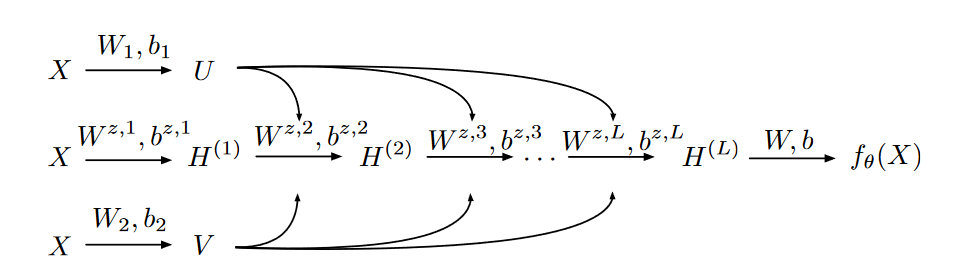

In [1]:
import torch.nn as nn
import torch.optim as optim
from torch import vmap
from torch.func import jacrev
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

PINN implementation with wen architeture


In [2]:
def ODE_1(t, y): # Exponential decay
    # y: R^1, lambda: 0.1
    y = torch.tensor(y, dtype=torch.float32).to(device)
    return -0.1 * y

ODE_1_y0 = torch.tensor([2.0]).to(device)

def ODE_2(t, y): # Van der Pol Oscillator
    # y: R^2, mu: 2
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32).to(device)
    
    x = y[0]
    dy = y[1]
    # Parameters
    omega = 1.0
    zeta = 0.5
    
    dydt = torch.stack([dy, -omega**2 * x - 2 * zeta * omega * dy]).to(device)
    return dydt

ODE_2_y0 = torch.tensor([2.0, 0.0]).to(device)

In [3]:
class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs,
        num_layers,
        num_neurons,
        num_outputs,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Basic neural network architecture with linear layers
        
        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers
        
        self.act = act

        self.encoder_1 = nn.Linear(num_inputs, num_neurons)
        self.encoder_2 = nn.Linear(num_inputs, num_neurons)

        self.layers = nn.ModuleList()

        # input layer
        self.layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            self.layers.append(nn.Linear(num_neurons, num_neurons))

        # output layer
        self.out_layer = nn.Linear(num_neurons, num_outputs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        H = x.reshape(-1, 1)
        
        U = self.act(self.encoder_1(H))
        V = self.act(self.encoder_1(H))
        
        for layer in self.layers:
            Z = self.act(layer(H))
            H = torch.mul((1 - Z), U) + torch.mul(Z, V)
        
        f = self.out_layer(H)

        
        return f.squeeze()

In [4]:
model = LinearNN(1, 4, 64, 2).to(device)

# Define the Jacobian function for a single input
def jacobian_fn(x):
    return jacrev(model)(x)

# Use vmap to compute Jacobians for each element in the batch
batched_jacobian_fn = vmap(jacobian_fn)

In [5]:
ODE_batch = vmap(ODE_2, in_dims=0)

In [6]:
def loss_fn(t: torch.Tensor):
    # INTERIOR LOSS
    # NN grads
    y = model(t)
    
    jacobians = batched_jacobian_fn(t)
    dydt = jacobians.squeeze(-1)
    # ODE actual grads
    ode_grads = ODE_batch(t, y)
    interior = dydt - ode_grads
    
    # BOUNDARY LOSS
    y_0 = model(torch.tensor([0.0]).to(device))
    
    boundary = y_0 - ODE_2_y0
    
    lambda_i = 1.0
    lambda_b = 0.5
    
    loss = nn.MSELoss(reduction='mean')
    interior_loss = loss(interior, torch.zeros_like(interior))
    boundary_loss = loss(boundary, torch.zeros_like(boundary))
    
    return lambda_i * interior_loss + lambda_b * boundary_loss
    

In [21]:
batch_size = 128  # number of colocation points to sample in the domain
num_iter = 1000  # maximum number of iterations
learning_rate = 1e-2  # learning rate
weight_decay = 1e-4  # weight decay
T = 10  # final time

optimzier = optim.Adam(model.parameters(), lr=learning_rate)


for i in range(num_iter):
    t = (torch.rand(batch_size) * T).to(device) 
    t.to(device)
    t.requires_grad_(True)
    
    loss = loss_fn(t)
    loss.backward()
    optimzier.step()
    optimzier.zero_grad()
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 0.0006124958745203912
Iteration 10, Loss: 0.16390378773212433
Iteration 20, Loss: 0.04080015793442726
Iteration 30, Loss: 0.001687781885266304
Iteration 40, Loss: 0.0034160842187702656
Iteration 50, Loss: 0.002602856606245041
Iteration 60, Loss: 0.0012779809767380357
Iteration 70, Loss: 0.0008659843588247895
Iteration 80, Loss: 0.0006367028690874577
Iteration 90, Loss: 0.0006156584131531417
Iteration 100, Loss: 0.0006062526954337955
Iteration 110, Loss: 0.0005982595030218363
Iteration 120, Loss: 0.0006223106174729764
Iteration 130, Loss: 0.0005532815121114254
Iteration 140, Loss: 0.000524099450558424
Iteration 150, Loss: 0.000557048013433814
Iteration 160, Loss: 0.0005669889505952597
Iteration 170, Loss: 0.0005460381507873535
Iteration 180, Loss: 0.0005693354178220034
Iteration 190, Loss: 0.0005404134280979633
Iteration 200, Loss: 0.0005946376477368176
Iteration 210, Loss: 0.000515729421749711
Iteration 220, Loss: 0.0005407011485658586
Iteration 230, Loss: 0.00050565

In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Solve the ODE system numerically
from scipy.integrate import solve_ivp

In [24]:
def ODE_1_np(t, y):
    dydt = ODE_1(t, y)
    return dydt.cpu().numpy()


def ODE_2_np(t,y):
    dydt = ODE_2(t, y)
    return dydt.cpu().numpy()

In [25]:
sol = solve_ivp(ODE_2_np, (0, T), ODE_2_y0.cpu().numpy(), method='RK45', t_eval=np.linspace(0, T, 100))

In [26]:
t = torch.linspace(0, T, 100).view(-1, 1).to(device)

t_np = t.cpu().detach().numpy()
y_pred_np = model(t).cpu().detach().numpy()


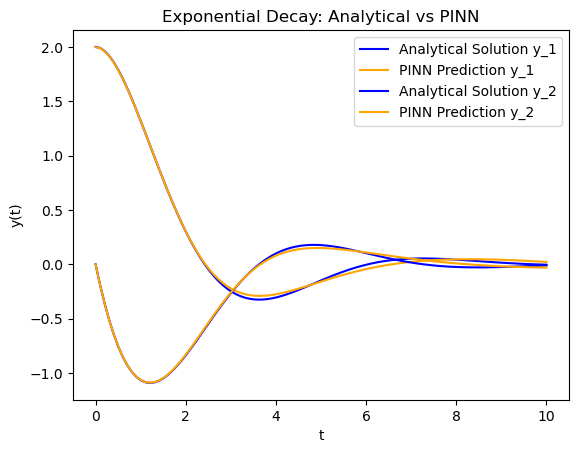

In [27]:
num_y = y_pred_np.shape[1]
for i in range(num_y):
    plt.plot(sol.t, sol.y.T[:, i], color='blue', label=f'Analytical Solution y_{i+1}')
    plt.plot(t_np, y_pred_np[:, i], color='orange', label=f'PINN Prediction y_{i+1}')

plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.title('Exponential Decay: Analytical vs PINN')
plt.show()